# **Visualizações GradCAM, GradCAM++ e Faster-ScoreCAM**

---


Nesta lição, usamos **Keras com TensorFlow 2.0** para visualizar o seguinte (veja abaixo). Isso ajuda você a entender melhor o que está acontecendo nos bastidores e desmistifica alguns dos aspectos do aprendizado profundo.

1. Aprenda a usar o GradCAM, GradCAM++, ScoreCAM e Faster-ScoreCAM para ver para onde nossa CNN está “olhando”

**Referências:**

https://github.com/keisen/tf-keras-vis


In [1]:
!pip install --upgrade tf-keras-vis tensorflow #Atualizando as libs

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

2025-10-08 01:00:15.751727: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 01:00:16.306726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759896016.495765    3909 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759896016.544734    3909 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759896016.964827    3909 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

1 GPUs


I0000 00:00:1759896022.917399    3909 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5630 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


### Carregando um modelo pré-treinado VGG16

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input #The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
from tensorflow.keras.preprocessing.image import load_img

#carregando
model = Model(weights = 'imagenet', include_top=True)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

#### **Carregar imagens**

O tf-keras-vis suporta a avaliação por lotes que inclui várias imagens. Aqui, carregamos três imagens de peixes dourados, ursos e rifles de assalto como dados de entrada.

In [5]:
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/goldfish.jpg
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/bear.jpg
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/soldiers.jpg

--2025-10-08 01:11:45--  https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/goldfish.jpg
Resolving github.com (github.com)... 4.228.31.150
Connecting to github.com (github.com)|4.228.31.150|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/keisen/tf-keras-vis/master/docs/examples/images/goldfish.jpg [following]
--2025-10-08 01:11:45--  https://raw.githubusercontent.com/keisen/tf-keras-vis/master/docs/examples/images/goldfish.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8833 (8.6K) [image/jpeg]
Saving to: ‘goldfish.jpg’

goldfish.jpg        100%[===================>]   8.63K  --.-KB/s    in 0.002s  

2025-10-08 01:11:46 (5.13 MB/s) - ‘goldfish.jpg’ saved [8833/8833]

--2

### Fazendo uma funçãozinha para ver as imagens 

In [8]:
from tensorflow.keras.preprocessing.image import load_img

images_titles = ['peixe dourado', 'bear', 'rifle']

imagem1 = load_img('goldfish.jpg', target_size=(224, 224)) #essa dimensão pois a entrada do nosso modelo é nesta, o que normalmente vem do conjunto do imagenet
imagem2 = load_img('bear.jpg', target_size=(224, 224))
imagem3 = load_img('soldiers.jpg', target_size=(224, 224))

images = np.asarray([np.array(imagem1),np.array(imagem2),np.array(imagem3),])

X = preprocess_input(images)
X

array([[[[ -80.939    ,  -88.779    ,  -80.68     ],
         [ -79.939    ,  -87.779    ,  -79.68     ],
         [ -79.939    ,  -87.779    ,  -79.68     ],
         ...,
         [ -76.939    ,  -87.779    , -100.68     ],
         [ -73.939    ,  -85.779    ,  -94.68     ],
         [ -74.939    ,  -84.779    ,  -93.68     ]],

        [[ -80.939    ,  -88.779    ,  -80.68     ],
         [ -79.939    ,  -87.779    ,  -79.68     ],
         [ -79.939    ,  -87.779    ,  -79.68     ],
         ...,
         [ -76.939    ,  -87.779    , -100.68     ],
         [ -74.939    ,  -86.779    ,  -95.68     ],
         [ -74.939    ,  -84.779    ,  -93.68     ]],

        [[ -80.939    ,  -88.779    ,  -80.68     ],
         [ -79.939    ,  -87.779    ,  -79.68     ],
         [ -79.939    ,  -87.779    ,  -79.68     ],
         ...,
         [ -76.939    ,  -87.779    , -100.68     ],
         [ -74.939    ,  -86.779    ,  -95.68     ],
         [ -75.939    ,  -85.779    ,  -94.68     ]],

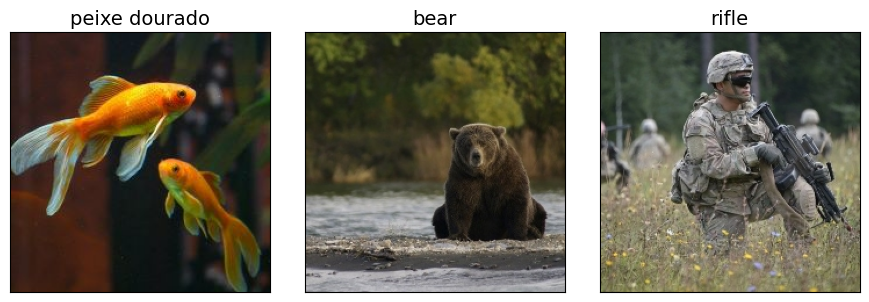

In [10]:
#Mostrando

subplot_args = { 'nrows': 1, 'ncols':3, 'figsize':(9,3), 'subplot_kw':{'xticks':[], 'yticks':[]} }

f, ax = plt.subplots(**subplot_args)

for i, title in enumerate(images_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])

plt.tight_layout()
plt.show()

## Definindo funções importantes

### Primeiro, algumas funções que retornam os scores da classificação e uma função de modificação das ultimas camadas do modelo

In [11]:
def loss(output):
    #utilizando os indexes do imagenet
    # 1 do peixe dourado
    # 2 do urso
    # 3 do rifle
    return (output[0][1], output[1][294], output[2][413])

In [12]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m
    """
    Então, quando a função de ativação softmax é aplicada à última camada do modelo, 
    ela pode impedir a geração das imagens de atenção, portanto, é necessário substituir a 
    função por uma função linear. Aqui, fazemos isso usando o model_modifier.
    
    """

# GradCAM

O GradCAM é outra forma de visualizar a atenção sobre a entrada. Em vez de usar gradientes em relação às saídas do modelo, ele usa a saída da penúltima camada Conv (antes da camada Dense).

Este método foi proposto em: https://arxiv.org/abs/1610.02391

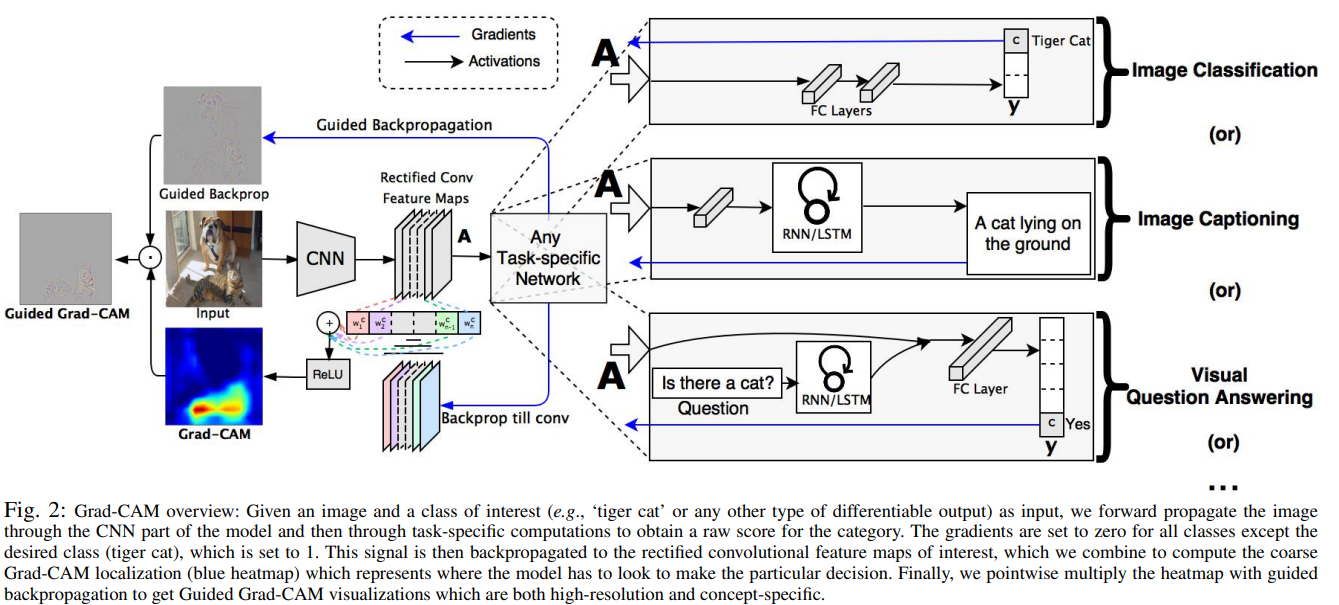

1. A imagem é processada pela rede, extraindo-se os mapas de características (feature maps) da última camada convolucional e o score da classe-alvo
2. Calcula-se o gradiente do score da classe-alvo em relação a todos os mapas de características da camada convolucional selecionada
3. Os gradientes são agregados espacialmente (Global Average Pooling) para obter um peso (αₖᶜ) que indica a importância de cada mapa de características para a classe.
4. Cria-se um mapa combinando os mapas de características ponderados pelos pesos αₖᶜ. A função ReLU é aplicada para destacar apenas as influências positivas
5. O mapa bruto é redimensionado para o tamanho da imagem original e sobreposto a ela como um heatmap, realçando as áreas relevantes

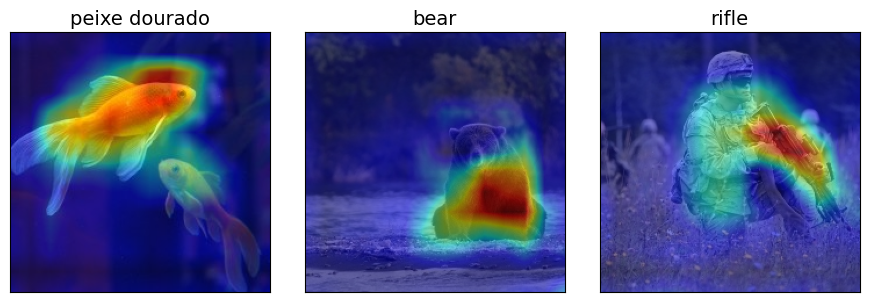

CPU times: user 235 ms, sys: 4.06 ms, total: 239 ms
Wall time: 244 ms


In [15]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Criando o objeto gradcam
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

#Gerando o mapa de calor. 
#Observe que estamos passando os scores, as imagens pre-processadas, e o index da camada alvo
cam = gradcam(loss,
              X,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(images_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
plt.tight_layout()
plt.show()

# GradCAM++

O GradCAM++ pode fornecer explicações visuais melhores das previsões do modelo CNN. No tf-keras-vis, a classe GradcamPlusPlus (GradCAM++) tem a maior parte da compatibilidade com o Gradcam. Portanto, você pode usar o GradcamPlusPlus se apenas substituir o nome da classe de Gradcam para GradcamPlusPlus.

Este método foi proposto em: https://arxiv.org/abs/1710.11063

A diferença fundamental está em como calcular os pesos de importância para cada mapa de características. Enquanto o GRAD-CAM original usa uma média global simples, o Grad-CAM++ usa uma fórmula mais sofisticada que considera a distribuição espacial dos gradientes.

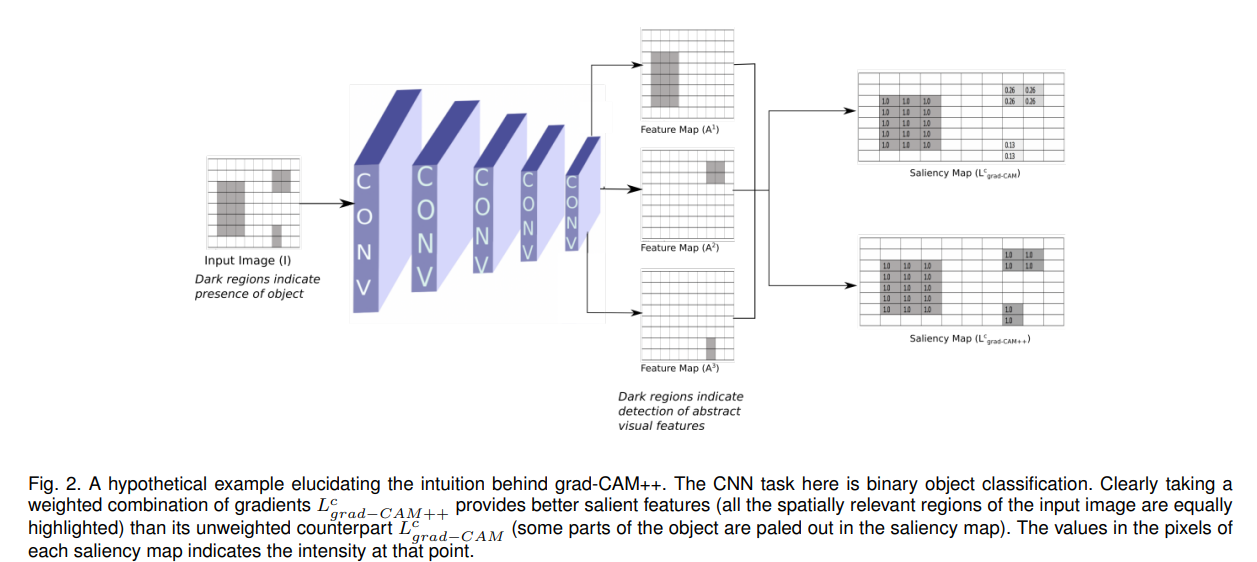

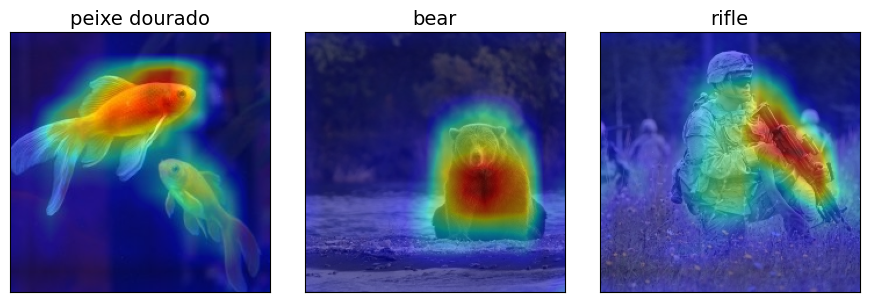

CPU times: user 242 ms, sys: 0 ns, total: 242 ms
Wall time: 240 ms


In [18]:
%%time

from tf_keras_vis.gradcam import GradcamPlusPlus

gradcam = GradcamPlusPlus(model,
                          model_modifier,
                          clone=False)


cam = gradcam(loss,
              X,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(images_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

# **ScoreCAM**

Por último, apresentamos o ScoreCAM. O SocreCAM é outro método que gera o Mapa de Ativação de Classe. A característica é que se trata de um método CAM sem gradiente, ao contrário do GradCAM/GradCAM++.

Por padrão, esse método leva muito tempo, portanto, na célula abaixo, o ScoreCAM NÃO é executado com a CPU.

Este método é proposto por: https://arxiv.org/abs/1910.01279

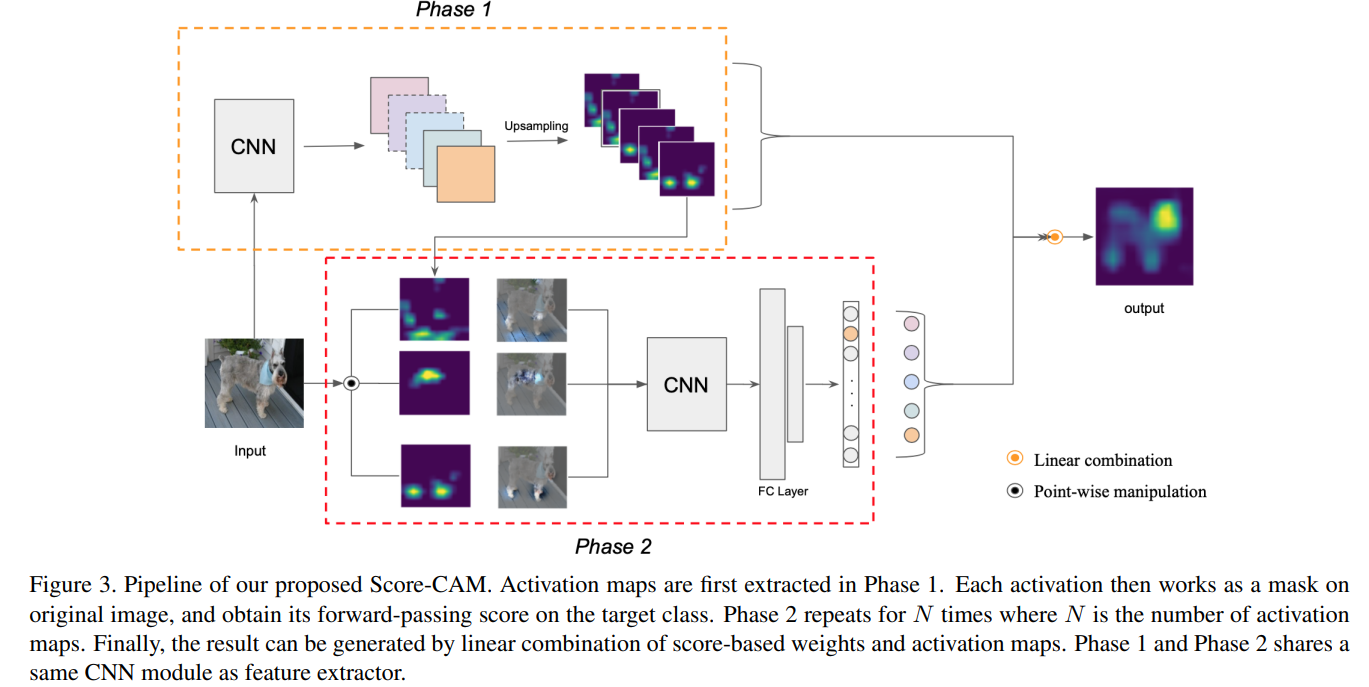

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step


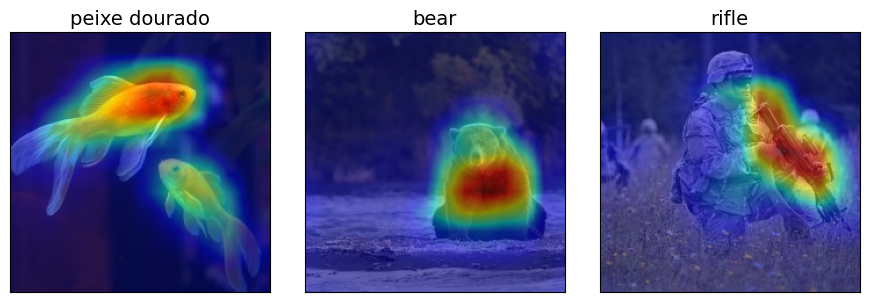

CPU times: user 13.7 s, sys: 1.52 s, total: 15.2 s
Wall time: 15 s


In [21]:
%%time

from tf_keras_vis.scorecam import ScoreCAM


scorecam = ScoreCAM(model, model_modifier, clone=False)

#RODAR NA GPU
if gpus > 0:
    
    cam = scorecam(loss,
                   X,
                   penultimate_layer=-1, # model.layers number
                  )
    cam = normalize(cam)

    f, ax = plt.subplots(**subplot_args)
    for i, title in enumerate(images_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=14)
        ax[i].imshow(images[i])
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Mude para GPU\n")

# Faster ScoreCAM

Consideramos que vários canais foram dominantes na geração do mapa de calor final. O Faster-Score-CAM adiciona o processamento de “usar apenas canais com grandes variações como imagens de máscara” ao Score-CAM. (max_N = -1 é o Score-CAM original).

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step 

/home/gabs/.local/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 224, 224, 3))',)
  warnings.warn(msg)
2025-10-08 02:39:51.511673: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_177_0', 36 bytes spill stores, 36 bytes spill loads

2025-10-08 02:39:51.579534: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_177', 4 bytes spill stores, 4 bytes spill loads

2025-10-08 02:39:51.750342: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_177', 720 bytes spill stores, 720 bytes spill loads

2025-10-08 02:39:51.8

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


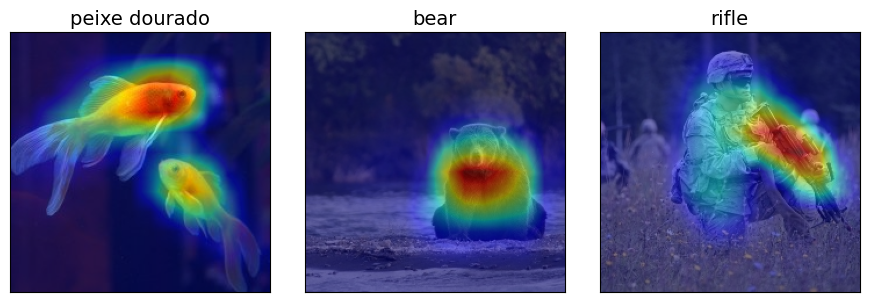

CPU times: user 18.4 s, sys: 274 ms, total: 18.7 s
Wall time: 8.41 s


In [22]:
%%time

# Create ScoreCAM object
scorecam = ScoreCAM(model, model_modifier, clone=False)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(loss,
               X,
               penultimate_layer=-1, # model.layers number
               max_N=10
              )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(images_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()